The idea and execution are inspired by https://github.com/gabrielpierobon/cnnshapes

In [1]:
%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
def get_shape(type_of_shape):
    images = []
    for img_path in glob.glob('shapes/' + type_of_shape 
                              + '/*.png'):
        images.append(mpimg.imread(img_path))
    columns = 5
    return images

In [3]:
circle_images = get_shape("circles")
square_images = get_shape("squares")
triangle_images = get_shape("triangles")

In [4]:
input_shape = circle_images[0].shape

In [5]:
def define_model(input_image_shape):
    classifier = Sequential()
    
    # First convolution layer
    classifier.add(Conv2D(32, (3, 3), 
                          padding='same', 
                          input_shape=input_image_shape,
                         activation='relu'))
    classifier.add(Conv2D(32, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2,2)))
    classifier.add(Dropout(0.5))
    
    # Second convolution layer
    classifier.add(Conv2D(64, (3, 3),
                         padding='same',
                         activation='relu'))
    classifier.add(Conv2D(64, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.5))
    
    # Third convolution layer
    classifier.add(Conv2D(64, (3, 3), 
                          padding='same', 
                          activation = 'relu'))
    classifier.add(Conv2D(64, (3, 3), activation='relu'))
    classifier.add(MaxPooling2D(pool_size=(2, 2)))
    classifier.add(Dropout(0.5)) # antes era 0.25
    
    # Flattening
    classifier.add(Flatten())
    
    # Full connection
    classifier.add(Dense(units=512, activation='relu'))
    classifier.add(Dropout(0.5))
    classifier.add(Dense(units=3, activation='softmax'))
    
    classifier.summary()
    classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy', 
                   metrics = ['accuracy'])
    return classifier

In [9]:
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_generator = train_datagen.flow_from_directory(
    'shapes',
    target_size=(28, 28),
    batch_size=16,
    class_mode='categorical',
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    'shapes', # same directory as training data
    target_size=(28, 28),
    batch_size=16,
    class_mode='categorical',
    subset='validation') # set as validation data

Found 240 images belonging to 3 classes.
Found 60 images belonging to 3 classes.


In [10]:
train_generator.image_shape

(28, 28, 3)

In [11]:
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5", 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)
model = define_model(input_shape)
history = model.fit_generator(train_generator,
                                steps_per_epoch = 100,
                                epochs = 20,
                                callbacks=[checkpointer],
                                validation_data = validation_generator,
                                validation_steps = 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 28, 28, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
__________

In [13]:
model.load_weights('best_weights.hdf5')

In [14]:
model.save('shapes_cnn.h5')

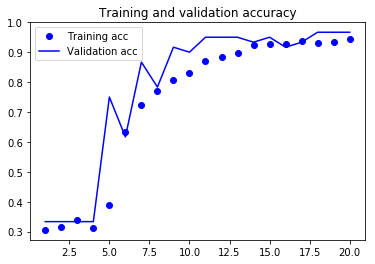

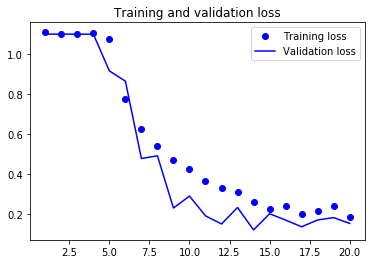

In [15]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

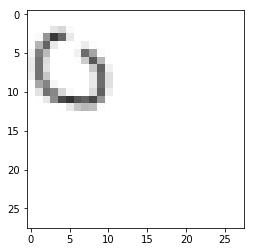

(1, 28, 28, 3)


In [17]:
img_path = '/home/cpu11455-local/Desktop/Personal_project/Shape_CNN/shapes/circles/drawing(37).png'

img = image.load_img(img_path, target_size=(28, 28))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

plt.imshow(img_tensor[0])
plt.show()

print(img_tensor.shape)

In [18]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print("Predicted class is:",classes)

Predicted class is: [0]


In [19]:
layer_outputs = [layer.output for layer in model.layers[:12]] # Extracts the outputs of the top 12 layers
activation_model = models.Model(inputs=model.input, outputs=layer_outputs) # Creates a model that will return these outputs, given the model input

In [21]:
activations = activation_model.predict(img_tensor)

In [22]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 28, 28, 32)


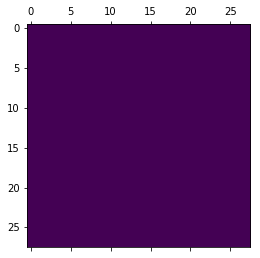

In [23]:
plt.matshow(first_layer_activation[0, :, :, 4], cmap='viridis')

/home/cpu11455-local/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in true_divide


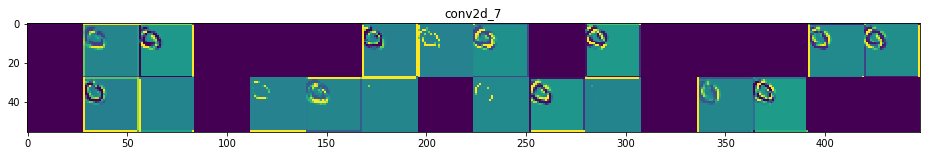

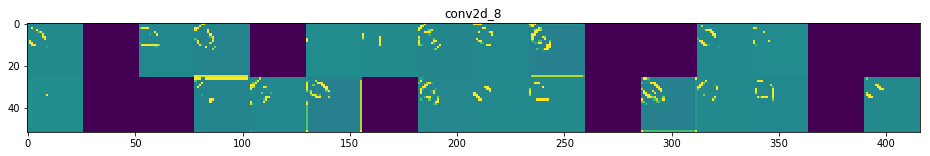

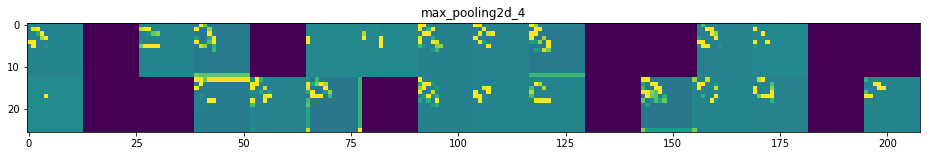

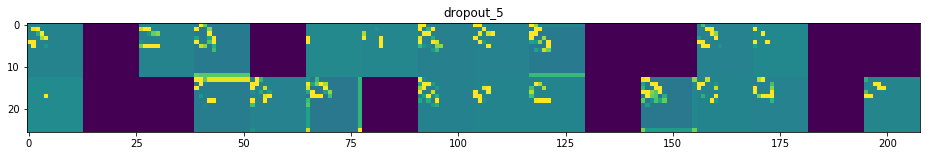

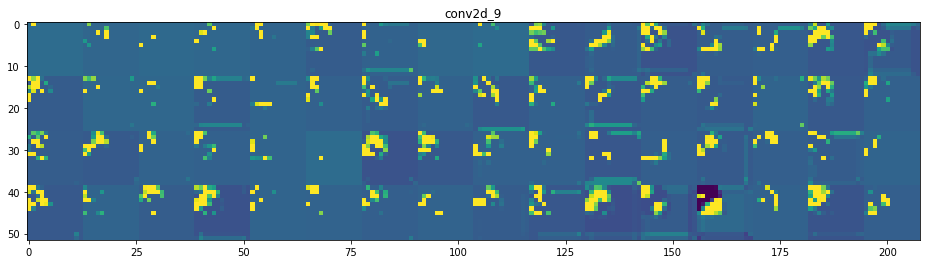

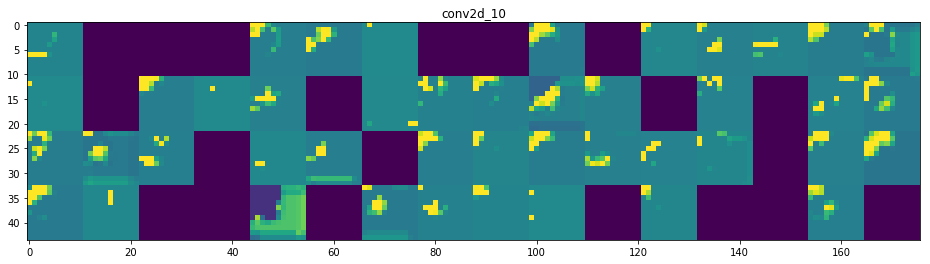

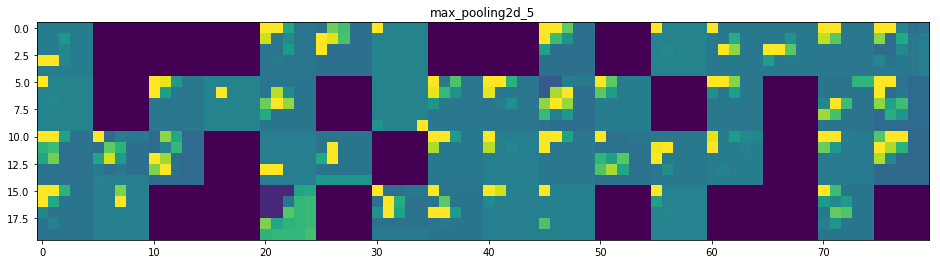

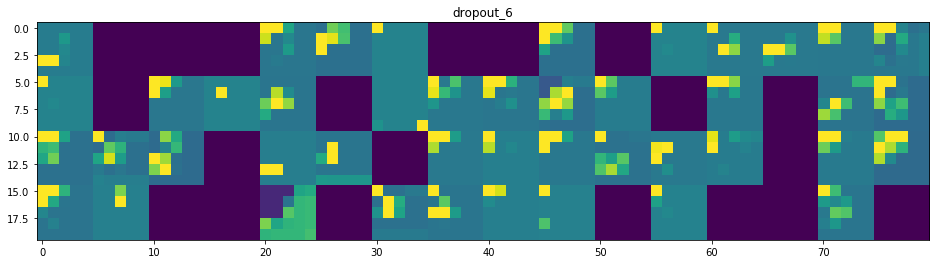

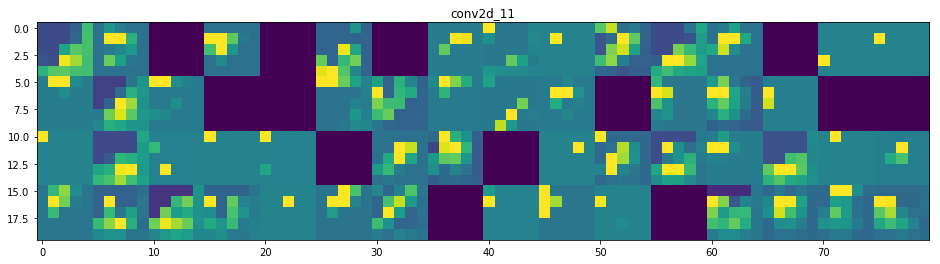

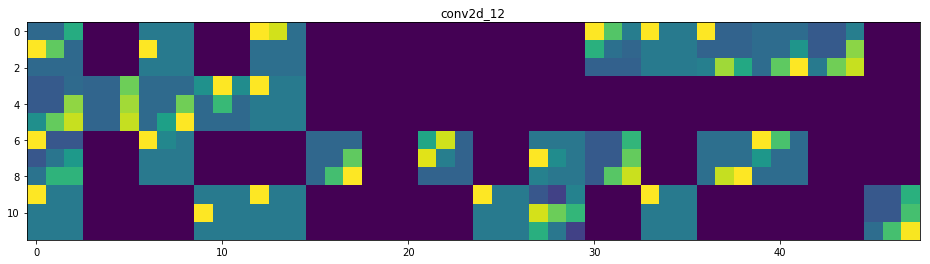

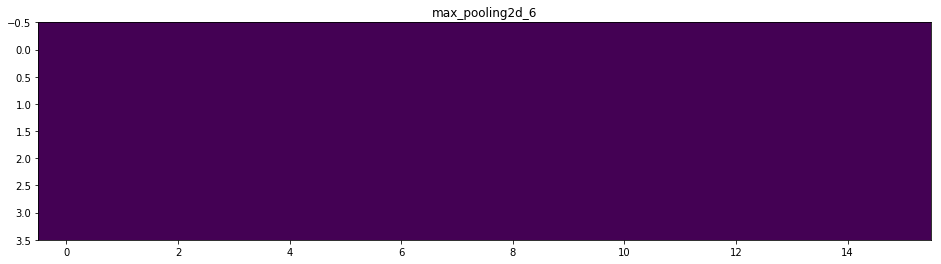

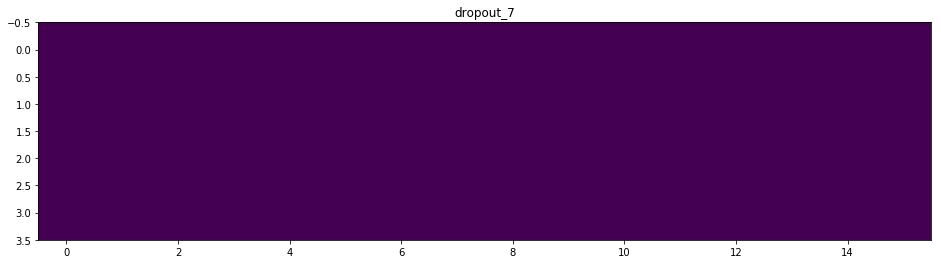

In [24]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')